In [1]:
import sys
import os
from pathlib import Path
sys.path.append(str(Path(os.path.abspath('')).parent))
from medmnist import OrganAMNIST
from data.data_classes import *
from data.graph_datasets import Graph_Dataset_CSV
from data.transforms import CuPIDTransform, SLICTransform
import matplotlib.pyplot as plt
import numpy as np
from data.data_classes import MyOmniglot
from math import log10, sqrt

In [2]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [33]:
def plot(idx, dataset, mode, num_cuboids):
    if mode == "CP":
        transform = CuPIDTransform(num_cuboids)
    elif mode == "SP":
        transform = SLICTransform(num_cuboids)

    # Data Source with Partition transform
    is_rgb = False
    match dataset.lower():
        case "mnist":
            original_dataset = MyMNIST().test()
            segmented_dataset = MyMNIST(transform).test()
            label = str(original_dataset[idx][1])
        case "cifar":
            original_dataset = MyCIFAR_10().test()
            segmented_dataset = MyCIFAR_10(transform).test()
            label = original_dataset.classes[original_dataset[idx][1]]
            is_rgb = True
        case "medmnist":
            original_dataset = MyMedMNIST().test()
            segmented_dataset = MyMedMNIST(transform).test()
            label = original_dataset.info["label"][str(original_dataset[idx][1].item())]
        case "omniglot":
            original_dataset = MyOmniglot().test()
            segmented_dataset = MyOmniglot(transform).test()
            label = original_dataset.classes[original_dataset[idx][1]]

    #TODO Make this not dependent on Graph Dataset CSV
    graphical_dataset = Graph_Dataset_CSV(root=r"D:\Python\Cuboidal_Partitioning_Deep_Learning_Project\data\csv\\", 
                                        name=dataset,
                                        split="Test",
                                        mode=mode,
                                        num_segments=num_cuboids, 
                                        x_center=True,
                                        y_center=True,
                                        colour=True,
                                        num_pixels=True)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(22, 5))
    fontsize = 13.5

    original_img = np.asarray(original_dataset[idx][0])
    segmented_img = segmented_dataset[idx][0]
    print(PSNR(original_img, segmented_img))
    data = graphical_dataset[idx].x.detach().numpy().copy()
    data[:, 0] *= original_img.shape[1]; data[:, 1] *= original_img.shape[0]; 
    if is_rgb:
        data[:, 5] *= (np.prod(original_img.shape[:2]))
    else:
        data[:, 3] *= (np.prod(original_img.shape[:2]))

    values, _ = graphical_dataset[idx].edge_index.t().sort()
    print(graphical_dataset[idx].x.shape[0])
    edges = values.unique(dim=0)

    ax1.imshow(original_img, cmap="gray")
    ax1.set_title(f"{dataset.upper()} Original Image {idx} | Label = {label.upper()}", fontsize = fontsize)
    ax1.set_xticks([])
    ax1.set_yticks([])

    ax2.imshow(segmented_img, cmap="gray")
    if mode == "CP":
        ax2.set_title(f"Image Segmented by CuPID-{num_cuboids}", fontsize = fontsize)
    elif mode == "SP":
        ax2.set_title(f"Image Segmented by SLIC-{num_cuboids}", fontsize = fontsize)
    ax2.set_xticks([])
    ax2.set_yticks([])

    ax3.invert_yaxis()
    if dataset != "omniglot":
        ax3.set_facecolor("black")
    if mode == "CP":
        ax3.set_title("CuPID Image as Graph", fontsize = fontsize)
    elif mode == "SP":
        ax3.set_title("SLIC Image as Graph", fontsize = fontsize)
    ax3.set_xticks([])
    ax3.set_yticks([])

    ax4.invert_yaxis()
    if dataset != "omniglot":
        ax4.set_facecolor("black")
    if mode == "CP":
        ax4.set_title("CuPID Image as Scaled Graph", fontsize = fontsize)
    elif mode == "SP":
        ax4.set_title("SLIC Image as Scaled Graph", fontsize = fontsize)
    ax4.set_xticks([])
    ax4.set_yticks([])

    # Add nodes
    for i in range(len(data)):
        if is_rgb:
            ax3.add_patch(plt.Circle((data[i][0], data[i][1]), 0.25, facecolor=data[i][2:5], edgecolor="white", linewidth=0.2))
            ax4.add_patch(plt.Circle((data[i][0], data[i][1]), 0.35*np.sqrt(data[i][5]), facecolor=data[i][2:5], edgecolor="white", linewidth=0.5))
        else:
            if dataset != "omniglot":
                ax3.add_patch(plt.Circle((data[i][0], data[i][1]), 0.25, facecolor=str(data[i][2].item()), edgecolor="white", linewidth=0.2))
                ax4.add_patch(plt.Circle((data[i][0], data[i][1]), 0.35*np.sqrt(data[i][3]), facecolor=str(data[i][2].item()), edgecolor="white", linewidth=0.5))
            else:
                ax3.add_patch(plt.Circle((data[i][0], data[i][1]), 0.25, facecolor=str(data[i][2].item()), edgecolor="black", linewidth=0.2))
                ax4.add_patch(plt.Circle((data[i][0], data[i][1]), 0.35*np.sqrt(data[i][3]), facecolor=str(data[i][2].item()), edgecolor="black", linewidth=0.5))

    # Add edges
    for i in range(len(edges)):
        # Get source cuboid information
        src_cuboid = data[edges[i][0]]
        x_src = src_cuboid[0]; y_src = src_cuboid[1]; col_src = src_cuboid[2]

        # Get destination cuboid information
        dst_cuboid = data[edges[i][1]]; x_dst = dst_cuboid[0]; y_dst = dst_cuboid[1]; col_dst = dst_cuboid[2]

        # Get average colour
        colour = (col_src + col_dst)/2

        # Plot line from (x_src, y_src) to (x_dst, y_dst)
        # ax3.plot([x_src, x_dst], [y_src, y_dst], color=str(colour.item()), linestyle='-', linewidth=0.5)
        # ax4.plot([x_src, x_dst], [y_src, y_dst], color=str(colour.item()), linestyle='-', linewidth=0.5)
        if dataset != "omniglot":
            ax3.plot([x_src, x_dst], [y_src, y_dst], color="w", linestyle='-', linewidth=0.5)
            ax4.plot([x_src, x_dst], [y_src, y_dst], color="w", linestyle='-', linewidth=0.5)
        else:
            ax3.plot([x_src, x_dst], [y_src, y_dst], color="k", linestyle='-', linewidth=0.5)
            ax4.plot([x_src, x_dst], [y_src, y_dst], color="k", linestyle='-', linewidth=0.5)

    ax3.set_box_aspect(1)
    ax4.set_box_aspect(1)
    plt.show()

33.0082096572775
64


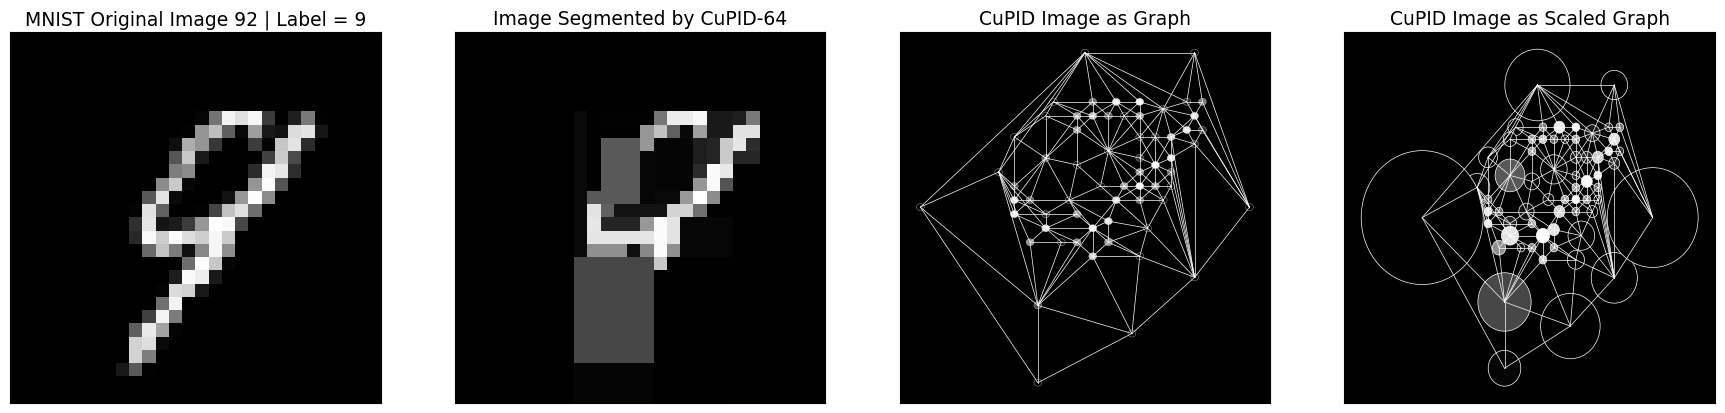

In [34]:
idx = 92
plot(idx, "mnist", "CP", 64)

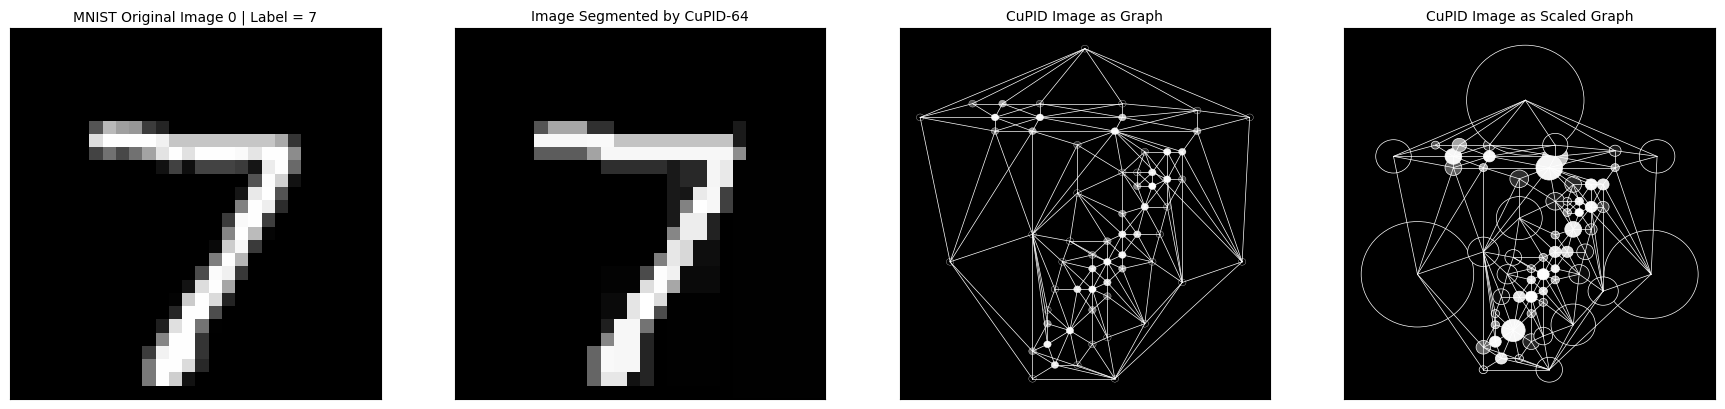